In [1]:
%matplotlib inline

from astropy.io import fits as pyfits
from astropy.table import Table
import numpy as np
from astropy.io.fits import Column
from datetime import datetime
import matplotlib.pyplot as plt
import os
import warnings
import requests

In [2]:
def download_from_dropbox(url):
    
    local_filename = "{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [3]:
# zeta parameters
#zeta_fname = download_from_dropbox("https://www.dropbox.com/s/4xoryra28lxhlrm/zeta_parameters.fits?dl=1")
zeta_fname = '/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/zeta_parameters.fits'
zeta_params=Table.read(zeta_fname)
slope = zeta_params['slope'][0]
intercept=zeta_params['intercept'][0]

In [ ]:
hubble_fname = download_from_dropbox("https://www.dropbox.com/s/dfmipz5jfzl9lja/input_for_hubble_debiased_catalog.fits?dl=1")

votes_data=Table.read(hubble_fname)

In [5]:
#Zeta-hat function for computing debiased values
z0 = 0.3 # we're correcting to redshift 0.3

def fhat_mel(f,z,z0,zeta_hat):
    
    val = 1. - (1. - f)*np.exp(-(z - z0)/ zeta_hat)
    
    return val
#assume zeta_hat is a linear function of surface brightness
def zeta_hat_lin(SB):
    
    val = 10.**((SB*slope) + intercept)
    return val

## Tables to included debiased values: hubble, goods_shallow, faded, recoloured
## Tables to be unaltered: sdss_single, sdss_coadd, fake_agn**

** fake agn have some extra meta to be included in vote catalog; that data isn't included here. 

In [6]:
# Debaised table:

def debiased_table(tablename):
    n_corrected = 0
    df=0
    table = (votes_data['Table']==tablename)
    data = votes_data[table]

    subjects=set(data['zooniverse_id'])

    intcolumn = np.zeros(len(subjects),dtype=int)
    floatcolumn = np.zeros(len(subjects),dtype=float)
    strcolumn = np.array([' ']*len(subjects),dtype='S24')

    from astropy.table import Column as TableColumn
    ex1 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_debiased_fraction', format='D')
    ex2 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_lower_limit', format='D')
    ex3 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_upper_limit', format='D')
    ex4 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_best_fraction',format='D')
    ex5 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_debiased_fraction', format='D')
    ex6 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_best_fraction',format='D')
    ex7 = Table.Column(name='t01_smooth_or_features_a01_smooth_flag',length=len(data),dtype=bool)
    ex8 = Table.Column(name='t01_smooth_or_features_a02_features_or_disk_flag',length=len(data),dtype=bool)
    ex9 = Table.Column(name='t01_smooth_or_features_a03_star_or_artifact_flag',length=len(data),dtype=bool)

    newtable = data.copy(copy_data=True)
    newtable.add_columns( (ex1, ex2, ex3, ex4, ex5, ex6, ex7, ex8, ex9) )

    z = 'Z_BEST'
    SB = 'GZ_MU_I'
    print 'Writing file...'
    for i,gal in enumerate(data):
        if i % 10000 == 0:
            t=datetime.now().time().isoformat()
            print 'Writing %ith row of %s at time %s' %(i,tablename,t)
        
        #new data: debiased vote fractions
        p_features_debiased = fhat_mel(gal['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'],gal[z],z0,zeta_hat_lin(gal[SB]))
        newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i] = p_features_debiased
    
        #write the 'best features' fraction column 
        if newtable.field('correction_type')[i]==0: #correctable
            p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i]
        elif newtable.field('correction_type')[i]==1: #uncorrectable
            p_features_best = np.nanmax([newtable.field('t01_smooth_or_features_a02_features_or_disk_lower_limit')[i],newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]])
        else:
            p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]
    
        newtable.field('t01_smooth_or_features_a02_features_or_disk_best_fraction')[i] = p_features_best
        
        #debiased, lower and upper, best smooth fractions based on 1 - p_artifact - p_features
        newtable.field('t01_smooth_or_features_a01_smooth_debiased_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_debiased
        newtable.field('t01_smooth_or_features_a01_smooth_lower_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_upper_limit']
        newtable.field('t01_smooth_or_features_a01_smooth_upper_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_lower_limit']

        p_smooth_best = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_best
        newtable.field('t01_smooth_or_features_a01_smooth_best_fraction')[i] = p_smooth_best
        
        #Potential error correction: some galaxies have negative smooth debiased values - this is when p_artifact
        #is particularly high. impose upper limit on p_features_debiased
        # so p_features_debiased + p_smooth_debiased + p_artifact_weighted = 1
        if p_smooth_best<0: # negative p_smooth; must adjust p_features to keep p_artifact fixed 
            p_smooth_best = 0
            old_p_features = p_features_best
            p_features_best = 1-p_smooth_best-gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction']

            newtable.field('t01_smooth_or_features_a01_smooth_best_fraction')[i]=0
            newtable.field('t01_smooth_or_features_a02_features_or_disk_best_fraction')[i]=p_features_best
            n_corrected+=1
            df += abs(old_p_features - p_features_best)
# Last - add smooth, features, artifact flags
        p_star = gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction']

        p_cut = 0.8
        
        if p_smooth_best>p_cut and gal['correction_type']!=3 and gal['correction_type']!=4: 
            newtable.field('t01_smooth_or_features_a01_smooth_flag')[i]=True
        else:
            newtable.field('t01_smooth_or_features_a01_smooth_flag')[i]=False
        if p_features_best>p_cut:
            newtable.field('t01_smooth_or_features_a02_features_or_disk_flag')[i]=True
        else:
            newtable.field('t01_smooth_or_features_a02_features_or_disk_flag')[i]=False
        if p_star>0.8:
            newtable.field('t01_smooth_or_features_a03_star_or_artifact_flag')[i]=True
        else:
            newtable.field('t01_smooth_or_features_a03_star_or_artifact_flag')[i]=False
        
    #write to file 
    #set path to file 
    fname = '/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/catalog_%i_%i_%i_%s.fits'%(datetime.now().month,datetime.now().day,datetime.now().year,tablename)    
    newtable.write(fname,overwrite=True)    
    
    print 'Debiased %s catalog includes %i subjects.'%(tablename,len(newtable))
    print 'Best features fractions were adjusted for %s %% of subjects for having a negative smooth best fractions, with an average correction of $\Delta$ f=%s.'%(round(float(n_corrected)/len(subjects),3),round(float(df)/n_corrected,2))

In [7]:
#Write debiased catalogs for 4 tables:
debiased_tables = ('hubble','goods_shallow','recoloured','faded')
for t in debiased_tables:
    debiased_table(t)

Writing file...
Writing 0th row of hubble at time 15:10:31.651265
Writing 10000th row of hubble at time 15:10:45.179370
Writing 20000th row of hubble at time 15:10:59.036222
Writing 30000th row of hubble at time 15:11:12.688432
Writing 40000th row of hubble at time 15:11:26.339254
Writing 50000th row of hubble at time 15:11:40.319956
Writing 60000th row of hubble at time 15:11:54.056759
Writing 70000th row of hubble at time 15:12:07.608610
Writing 80000th row of hubble at time 15:12:20.939595
Writing 90000th row of hubble at time 15:12:34.331882
Writing 100000th row of hubble at time 15:12:47.686521
Writing 110000th row of hubble at time 15:13:01.003314
Debiased hubble catalog includes 113705 subjects.
Best features fractions were adjusted for 0.012 % of subjects for having a negative smooth best fractions, with an average correction of $\Delta$ f=0.04.
Writing file...
Writing 0th row of goods_shallow at time 15:13:07.526851
Debiased goods_shallow catalog includes 6144 subjects.
Best f

In [60]:
# Unaltered table (but add smooth/features/artifact flags:

def copy_table(tablename):

    table = (votes_data['Table']==tablename)
    data = votes_data[table]
    
    ex7 = Table.Column(name='t01_smooth_or_features_a01_smooth_flag',length=len(data),dtype=bool)
    ex8 = Table.Column(name='t01_smooth_or_features_a02_features_or_disk_flag',length=len(data),dtype=bool)
    ex9 = Table.Column(name='t01_smooth_or_features_a03_star_or_artifact_flag',length=len(data),dtype=bool)

    newtable = data.copy(copy_data=True)
    newtable.add_columns((ex7,ex8,ex9))
    
    # Last - add smooth, features, artifact flags
    for i,gal in enumerate(data):    
        
        p_smooth = gal['t01_smooth_or_features_a01_smooth_weighted_fraction']
        p_features = gal['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
        p_star = gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction']

        p_cut = 0.8
        
        if p_smooth>p_cut and gal['correction_type']!=3 and gal['correction_type']!=4: 
            newtable.field('t01_smooth_or_features_a01_smooth_flag')[i]=True
        else:
            newtable.field('t01_smooth_or_features_a01_smooth_flag')[i]=False
        if p_features>p_cut:
            newtable.field('t01_smooth_or_features_a02_features_or_disk_flag')[i]=True
        else:
            newtable.field('t01_smooth_or_features_a02_features_or_disk_flag')[i]=False
        if p_star>0.8:
            newtable.field('t01_smooth_or_features_a03_star_or_artifact_flag')[i]=True
        else:
            newtable.field('t01_smooth_or_features_a03_star_or_artifact_flag')[i]=False

    
    #write to file 
    #set path to file 
    fname = '/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/catalog_%i_%i_%i_%s.fits'%(datetime.now().month,datetime.now().day,datetime.now().year,tablename)    
    newtable.write(fname,overwrite=True)    
    
    print ' %s catalog includes %i subjects.\n'%(tablename,len(newtable))

In [61]:
#Write debiased catalogs for 2 tables:
copied_tables = ('sdss_single','sdss_coadd')
for t in copied_tables:
    copy_table(t)

 sdss_single catalog includes 21522 subjects.

 sdss_coadd catalog includes 30339 subjects.



In [8]:
#check corrections in hubble table

z = 'Z_BEST'
SB = 'GZ_MU_I'

h = (votes_data['Table']=='hubble')
hubble_data=votes_data[h]
#hubble_data = Table.read('/home/mel/Dropbox/gzhubble/hubble_files/catalog_debiasing_files/new_sb_method/catalog_5_26_2016_hubble.fits')

correctable=(hubble_data['correction_type']==0)
uncorrectable=(hubble_data['correction_type']==1)
nei=(hubble_data['correction_type']==3)

old_votes=hubble_data['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
old_z=hubble_data[z]
old_mu=hubble_data[SB]

new_c=fhat_mel(old_votes[correctable],old_z[correctable],z0,zeta_hat_lin(old_mu[correctable]))
new_unc=fhat_mel(old_votes[uncorrectable],old_z[uncorrectable],z0,zeta_hat_lin(old_mu[uncorrectable])) #debiased value
#new_unc = old_lower_limit[uncorrectable] #lower limit
new_nei=fhat_mel(old_votes[nei],old_z[nei],z0,zeta_hat_lin(old_mu[nei]))

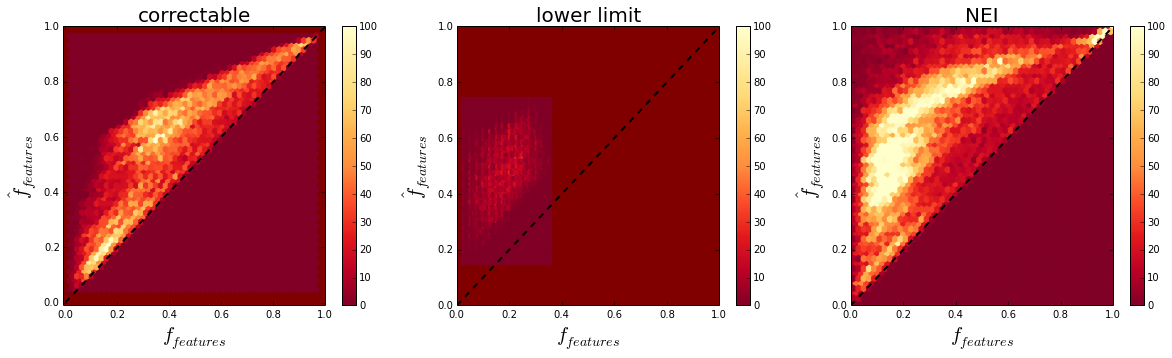

In [11]:
# 2D histogram of new p_features distribution
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(131)
hex1 = ax1.hexbin(old_votes[correctable],new_c, cmap=plt.cm.YlOrRd_r,gridsize=50,vmin =0,vmax=100)
ax1.set_xlabel(r'$f_{features}$',fontsize=20)
ax1.set_ylabel(r'$\hat f_{features}$',fontsize=20)
cb1 = plt.colorbar(hex1)
ax1.set_title('correctable',fontsize=20)
ax1.set_axis_bgcolor('#800000')

# Add the one-to-one line for comparision.
# Upper left = boosted p_features for z > 0.3
# Lower right = depressed p_features for z < 0.3

ax1.plot([0,1],[0,1],color='k',lw=2,ls='--')

# Try it with Mel's new function
ax2 = fig.add_subplot(133)
hex2 = ax2.hexbin(old_votes[nei],new_nei, cmap=plt.cm.YlOrRd_r,gridsize=50,vmax=100)
ax2.set_xlabel(r'$f_{features}$',fontsize=20)
ax2.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
cb2 = plt.colorbar(hex2)
ax2.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax2.set_title('NEI',fontsize=20)

ax3 = fig.add_subplot(132)
hex3 = ax3.hexbin(old_votes[uncorrectable],new_unc, cmap=plt.cm.YlOrRd_r,gridsize=50,vmin =0, vmax=100)
ax3.set_xlabel(r'$f_{features}$',fontsize=20)
ax3.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
cb3 = plt.colorbar(hex3)
ax3.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax3.set_title('lower limit',fontsize=20)
ax3.set_axis_bgcolor('#800000')

plt.savefig('../../writeup/figures/debiased_corrections.pdf')
